In [40]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from tqdm import tqdm
import utils.augmentation as aug
import Helper as hlp

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

seed = 42

2.10.0


In [6]:
training_labels = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe": 4,
    "Time": 5,
    "Brain": 6,
    "Echoes": 7,
    "Wearing": 8,
    "Sorrow": 9,
    "Hey": 10,
    "Shine": 11,
}

### DATA PREPARATION

In [7]:
data = np.load("../../data/x_train.npy")
target = np.load("../../data/y_train.npy")

In [8]:
#SHUFFLE DATA
p = np.random.permutation(data.shape[0])
data = data[p]
target = target[p]

In [9]:
data[0].shape

(36, 6)

In [10]:
#NAME OF THE FEATURES COLUMNS
feature_names = ['Attribute-0', 'Attribute-1', 'Attribute-2', 'Attribute-3', 'Attribute-4', 'Attribute-5']
#COLUMNS NAMES (include ID and TARGET and all features)
columns = feature_names.copy()
columns.insert(0, 'ID')
columns.append('Target')

In [11]:
def add_shift(df, column_names=None, shift=1, avg=False):
    if column_names is None:
        column_names = []
    if avg:
        new_columns = [item + " - A" + str(shift) for item in column_names]
        df[new_columns] = df[column_names].rolling(shift).mean()
    else:
        new_columns = [item + " - S" + str(shift) for item in column_names]
        df[new_columns] = df[column_names].shift(shift)

    #Replace Nan with 0
    df[new_columns] = df[new_columns].replace(np.nan, 0)
    return df

In [12]:
X = pd.DataFrame(columns=columns)
remove_shifts = True
for i in tqdm(range(0, data.shape[0])):
    new_seq = pd.DataFrame(data[i], columns=feature_names)
    new_seq['Target'] = target[i]
    new_seq['ID'] = i
    if not remove_shifts:
        new_seq = add_shift(new_seq, feature_names, shift=2)
        new_seq = add_shift(new_seq, feature_names, shift=5)
        new_seq = add_shift(new_seq, feature_names, shift=5, avg=True)
        new_seq = add_shift(new_seq, feature_names, shift=10)
        new_seq = add_shift(new_seq, feature_names, shift=10, avg=True)
    X = pd.concat([X, new_seq])

X.shape

100%|██████████| 2429/2429 [00:02<00:00, 957.93it/s] 


(87444, 8)

In [13]:
X

,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,-15.20700,6.0174,52.34200,-0.52796,19.6780,21.8790,3
1,0,-20.42100,6.1425,22.12700,-3.02420,7.8850,35.0360,3
2,0,-20.27200,8.6925,-11.19600,-6.23890,-1.3469,-40.1540,3
3,0,-12.74500,15.2980,-0.39658,-8.71060,18.7920,24.7710,3
4,0,0.63179,21.6370,13.65200,-9.34230,17.5120,58.0200,3
...,...,...,...,...,...,...,...,...
31,2428,-4.41820,432.3100,-54.61000,2.23720,-3.5267,2.0610,3
32,2428,44.43000,460.3500,150.47000,-93.17200,-40.5670,-9.4176,3
33,2428,86.15300,429.5700,595.55000,69.62700,370.9200,16.3580,3
34,2428,86.91500,309.2600,733.94000,363.43000,743.3500,-19.0210,3


In [14]:
feature_names = X.columns[X.columns != 'ID']
feature_names = feature_names[feature_names != 'Target']
feature_names = feature_names.tolist()
feature_names

['Attribute-0',
 'Attribute-1',
 'Attribute-2',
 'Attribute-3',
 'Attribute-4',
 'Attribute-5']

In [15]:
X

,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,-15.20700,6.0174,52.34200,-0.52796,19.6780,21.8790,3
1,0,-20.42100,6.1425,22.12700,-3.02420,7.8850,35.0360,3
2,0,-20.27200,8.6925,-11.19600,-6.23890,-1.3469,-40.1540,3
3,0,-12.74500,15.2980,-0.39658,-8.71060,18.7920,24.7710,3
4,0,0.63179,21.6370,13.65200,-9.34230,17.5120,58.0200,3
...,...,...,...,...,...,...,...,...
31,2428,-4.41820,432.3100,-54.61000,2.23720,-3.5267,2.0610,3
32,2428,44.43000,460.3500,150.47000,-93.17200,-40.5670,-9.4176,3
33,2428,86.15300,429.5700,595.55000,69.62700,370.9200,16.3580,3
34,2428,86.91500,309.2600,733.94000,363.43000,743.3500,-19.0210,3


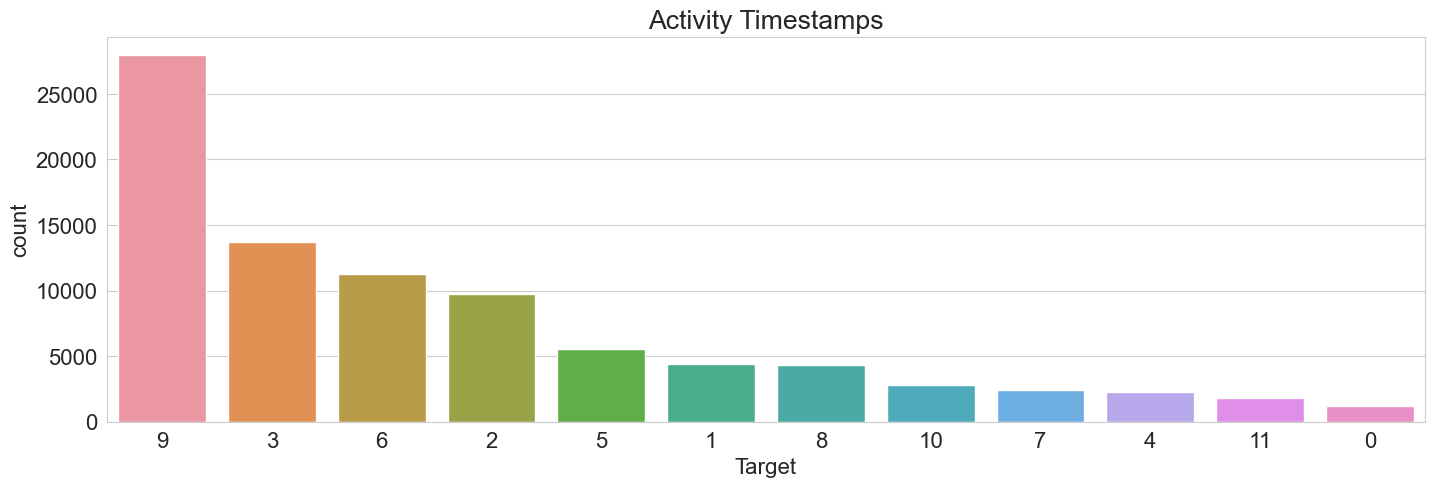

In [16]:
# Inspect activities timestamps
plt.figure(figsize=(17, 5))
sns.countplot(x='Target', data=X, order=X.Target.value_counts().index)
plt.title('Activity Timestamps')
plt.show()

### DISPLAY DATA

In [17]:
X.iloc[[0]]


,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,-15.207,6.0174,52.342,-0.52796,19.678,21.879,3


In [18]:
def inspect_activity(activity, df):
    data = df[df['Target'] == activity][feature_names]
    axis = data.plot(subplots=True, figsize=(17, 9), title=activity)
    for ax in axis:
        ax.legend(loc='lower right')

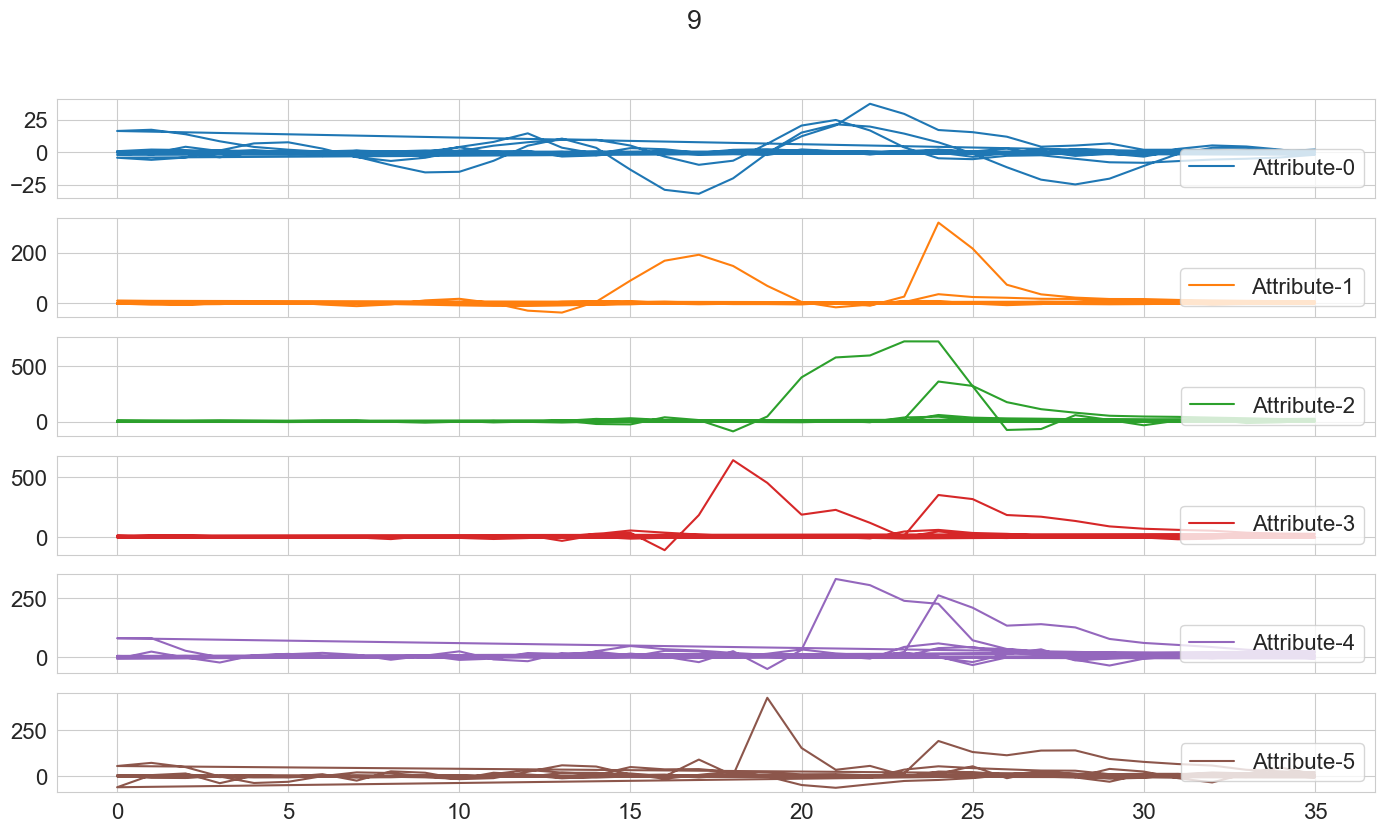

In [19]:
class_to_plot = 9
inspect_activity(class_to_plot, X.head(360))

# SPLIT DATA INTO TRAIN / TEST
- Split data into Train and test seqeuences using sequence ID
- We also convert target into OneHotEncoding
- Normalize Data using MinMax Scaler


In [20]:
test_split = 0.2
test_split_ID = data.shape[0] - test_split * data.shape[0]

# Split over users
df_train = X[X['ID'] <= test_split_ID]
df_test = X[X['ID'] > test_split_ID]
X.set_index('ID')
df_train.shape, df_test.shape

((69984, 8), (17460, 8))

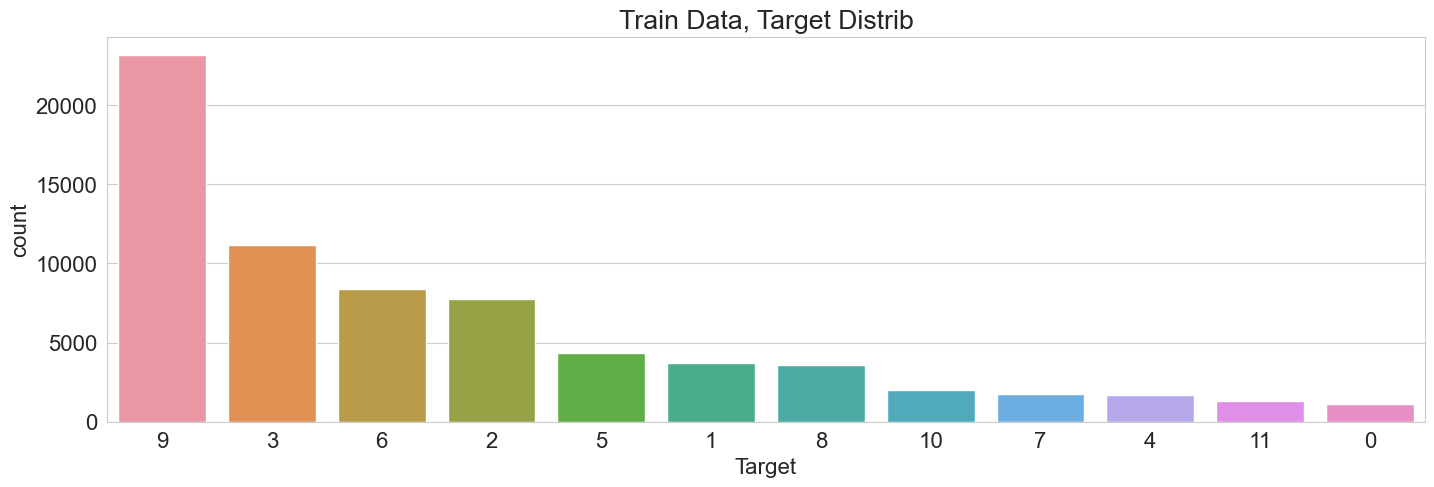

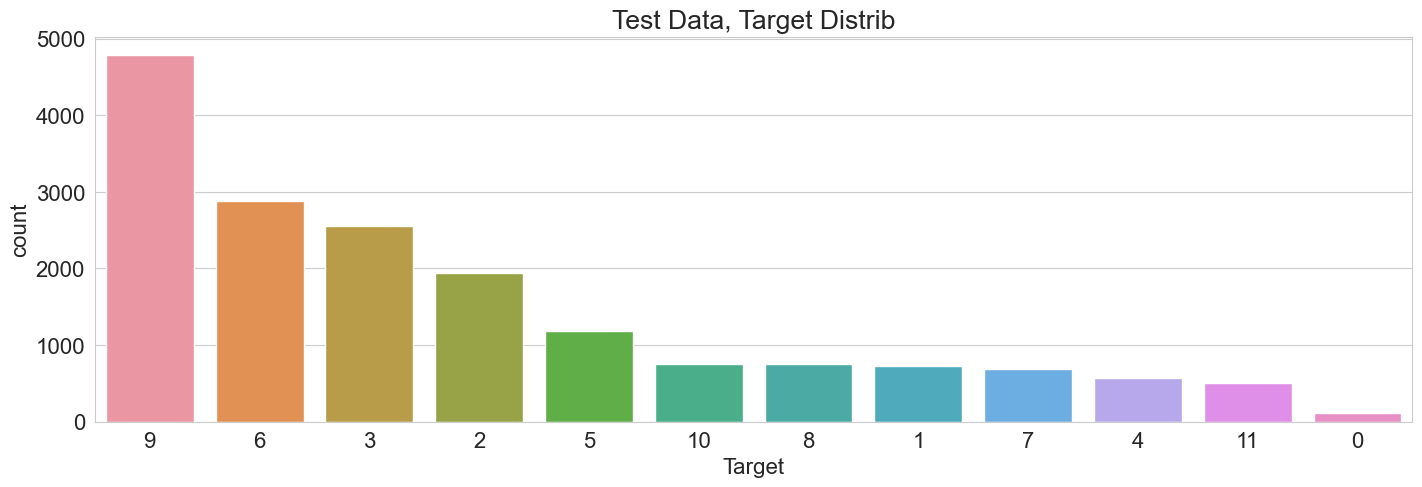

In [21]:
# Inspect activities timestamps
plt.figure(figsize=(17, 5))
sns.countplot(x='Target', data=df_train, order=df_train.Target.value_counts().index)
plt.title('Train Data, Target Distrib')
plt.show()

# Inspect activities timestamps
plt.figure(figsize=(17, 5))
sns.countplot(x='Target', data=df_test, order=df_test.Target.value_counts().index)
plt.title('Test Data, Target Distrib')
plt.show()

In [22]:
df_train

,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,-15.20700,6.0174,52.34200,-0.52796,19.6780,21.8790,3
1,0,-20.42100,6.1425,22.12700,-3.02420,7.8850,35.0360,3
2,0,-20.27200,8.6925,-11.19600,-6.23890,-1.3469,-40.1540,3
3,0,-12.74500,15.2980,-0.39658,-8.71060,18.7920,24.7710,3
4,0,0.63179,21.6370,13.65200,-9.34230,17.5120,58.0200,3
...,...,...,...,...,...,...,...,...
31,1943,-8.86670,-3.9878,-0.33321,-1.66470,14.4470,-4.1148,9
32,1943,-9.25560,-4.5399,10.85900,-1.04060,-2.3019,19.4590,9
33,1943,-8.80910,-4.2175,10.80100,-11.71700,-6.7593,14.8450,9
34,1943,-6.63270,-3.0863,-0.37651,-22.63000,-1.6043,60.0480,9


In [23]:
# Apply MinMaxScaler to the useful features
normalize = True
norm_type = 1  # 0 -> MinMax, 1 Mean(0) Std dev(1)

#NORMALIZE DATA
if normalize:
    #MinMax
    if norm_type == 0:
        min = df_train[feature_names].min()
        max = df_train[feature_names].max()
        df_train[feature_names] = (df_train[feature_names] - min) / (max - min)
        df_test[feature_names] = (df_test[feature_names] - min) / (max - min)
    #Mean,Std
    if norm_type == 1:
        mean = df_train[feature_names].mean()
        var = df_train[feature_names].std()
        df_train[feature_names] = (df_train[feature_names] - mean) / var
        df_test[feature_names] = (df_test[feature_names] - mean) / var

df_train

/var/folders/0y/xb7crskj6j96cb2cmd4bsvm00000gn/T/ipykernel_61735/488657213.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[feature_names] = (df_train[feature_names] - mean) / var
/var/folders/0y/xb7crskj6j96cb2cmd4bsvm00000gn/T/ipykernel_61735/488657213.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[feature_names] = (df_test[feature_names] - mean) / var


,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,-0.092348,-0.017289,0.031730,-0.049209,-0.022254,-0.013160,3
1,0,-0.111488,-0.017126,-0.010599,-0.052708,-0.039005,0.004105,3
2,0,-0.110941,-0.013817,-0.057281,-0.057215,-0.052118,-0.094558,3
3,0,-0.083310,-0.005245,-0.042152,-0.060681,-0.023512,-0.009365,3
4,0,-0.034205,0.002981,-0.022472,-0.061566,-0.025330,0.034264,3
...,...,...,...,...,...,...,...,...
31,1943,-0.069073,-0.030272,-0.042064,-0.050802,-0.029684,-0.047268,9
32,1943,-0.070501,-0.030989,-0.026384,-0.049927,-0.053475,-0.016335,9
33,1943,-0.068862,-0.030570,-0.026466,-0.064896,-0.059806,-0.022390,9
34,1943,-0.060872,-0.029102,-0.042124,-0.080195,-0.052484,0.036925,9


In [24]:
def build_sequence(df):
    x = df.groupby('ID')[feature_names].apply(lambda x: x.values.tolist()).tolist()
    y = df.groupby(['ID', 'Target'])[['Target']].mean()

    return np.array(x), np.array(y)

In [25]:
x_train, y_train = build_sequence(df_train)
x_test, y_test = build_sequence(df_test)
#X,Y = build_sequence(X) -> TEST IF TARGET ARE EXTRACTED IN CORRECT ORDER (WORK)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1944, 36, 6), (1944, 1), (485, 36, 6), (485, 1))

# Augmentation

In [26]:
import utils.augmentation as aug

In [27]:
def plot_aug(x, x_aug):
    # color red for original and green for augmented
    plt.plot(x, color='red')
    plt.plot(x_aug, color='green')




series = x_train

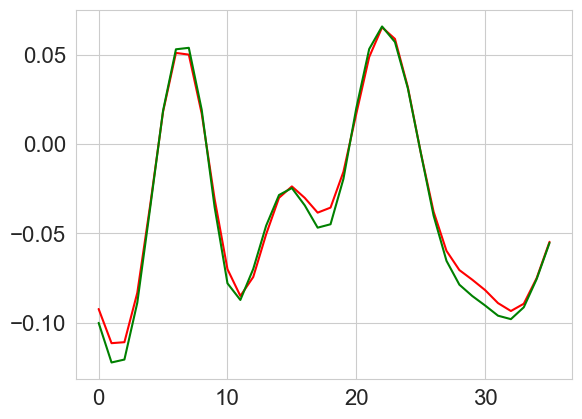

In [29]:
plot_aug(series[0, :, 0],  aug.magnitude_warp(series, sigma=0.1, knot=10)[0, :, 0])


In [42]:
distributions = hlp.get_classes_distribution(df_train, "Target")

0     0.015947
1     0.052984
2     0.111111
3     0.159465
4     0.023663
5     0.061728
6     0.119856
7     0.025206
8     0.050926
9     0.331276
10    0.028807
11    0.019033
Name: Target, dtype: float64

1. Random Noise Injection: This function adds random noise to the data series in order to increase the variability of the data and make it more suitable for a neural network.

In [54]:

def random_noise_injection(data, sigma=0.001):
    noise = np.random.normal(0, sigma, data.shape)
    return data + noise


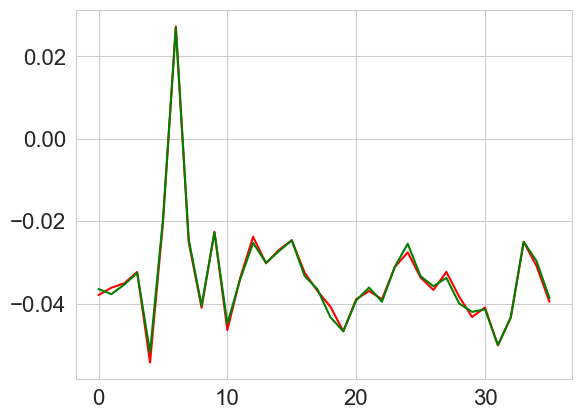

In [56]:
x_noise = random_noise_injection(x_train )
plot_aug(x_train[0, :, 0], x_noise[0, :, 0])

2. Data Scaling: This function scales the data series to a range between 0 and 1, which is a common pre-processing step for neural networks.

In [ ]:

def data_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)


3. Data Augmentation: This function randomly flips, rotates, and shifts the data series in order to create new data points.

In [ ]:

def data_augmentation(data):
    augmented_data = np.copy(data)
    for i in range(data.shape[0]):
        if np.random.rand() > 0.5:
            augmented_data[I] = np.flip(data[i])
        if np.random.rand() > 0.5:
            augmented_data[I] = np.rot90(data[i])
        if np.random.rand() > 0.5:
            augmented_data[i] = np.roll(data[i], np.random.randint(1, data.shape[1]))
    return augmented_data

In [30]:
x_train, y_train = build_sequence(df_train)
x_test, y_test = build_sequence(df_test)
#X,Y = build_sequence(X) -> TEST IF TARGET ARE EXTRACTED IN CORRECT ORDER (WORK)


x_train = np.append(x_train, aug.jitter(x_train, sigma=0.1)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000])
x_train = np.append(x_train, aug.magnitude_warp(series, sigma=0.1, knot=10)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000])
# x_train = np.append(x_train, aug.permutation(series, max_segments=3)[:1000], axis=0)
# y_train = np.append(y_train, y_train[:1000])

indexes = np.random.choice(x_train.shape[0], x_train.shape[0])
x_train = x_train[indexes]
y_train = y_train[indexes]

In [31]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5832, 36, 6), (5832, 12), (485, 36, 6), (485, 12))

# NOW USE THE GENERATED TIME SERIES TO TRAIN OUR MODELS

Vanilla Attempts:
-CNN1D : 

In [32]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200
input_shape, classes

((36, 6), 12)

### CNN-1D Basic model

In [33]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128, 5, padding='same', activation='relu')(input_layer)
    cnn = tfkl.Conv1D(128, 5, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 1, padding='same', activation='relu')(cnn)
    cnn = tfkl.Conv1D(128, 1, padding='same', activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.2, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [34]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Metal device set to: Apple M1 Pro


2022-12-13 19:25:46.865847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-13 19:25:46.866755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           3968      
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 128)           82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 128)           49280     
                                                             

In [35]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-13 19:25:48.146810: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-13 19:25:48.582736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 3s 23ms/step - loss: 2.1538 - accuracy: 0.3428 - val_loss: 1.8906 - val_accuracy: 0.3921 - lr: 0.0010
Epoch 2/200


2022-12-13 19:25:50.916066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 18ms/step - loss: 1.8538 - accuracy: 0.3862 - val_loss: 1.7578 - val_accuracy: 0.3990 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 1s 17ms/step - loss: 1.7573 - accuracy: 0.4059 - val_loss: 1.7281 - val_accuracy: 0.4178 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 1s 17ms/step - loss: 1.6164 - accuracy: 0.4421 - val_loss: 1.5127 - val_accuracy: 0.4846 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 1s 18ms/step - loss: 1.4835 - accuracy: 0.4823 - val_loss: 1.4017 - val_accuracy: 0.5171 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 1s 19ms/step - loss: 1.3555 - accuracy: 0.5244 - val_loss: 1.3225 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 1s 16ms/step - loss: 1.3655 - accuracy: 0.5322 - val_loss: 1.4195 - val_accuracy: 0.4914 - lr: 0.0010
Epoch 8/200
41/41 [==============================] - 1s 16ms/step - loss: 1.2932 -

In [258]:
#model.save('Preprocess-CNN')

In [293]:
# Predict the test set with the 1DCNN
predictions = model.predict(x_test)
predictions.shape

15/16 [===========================>..] - ETA: 0s

2022-12-12 19:35:18.321691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 7ms/step


(485, 12)

Accuracy: 0.6227
Precision: 0.6385
Recall: 0.5575
F1: 0.5814


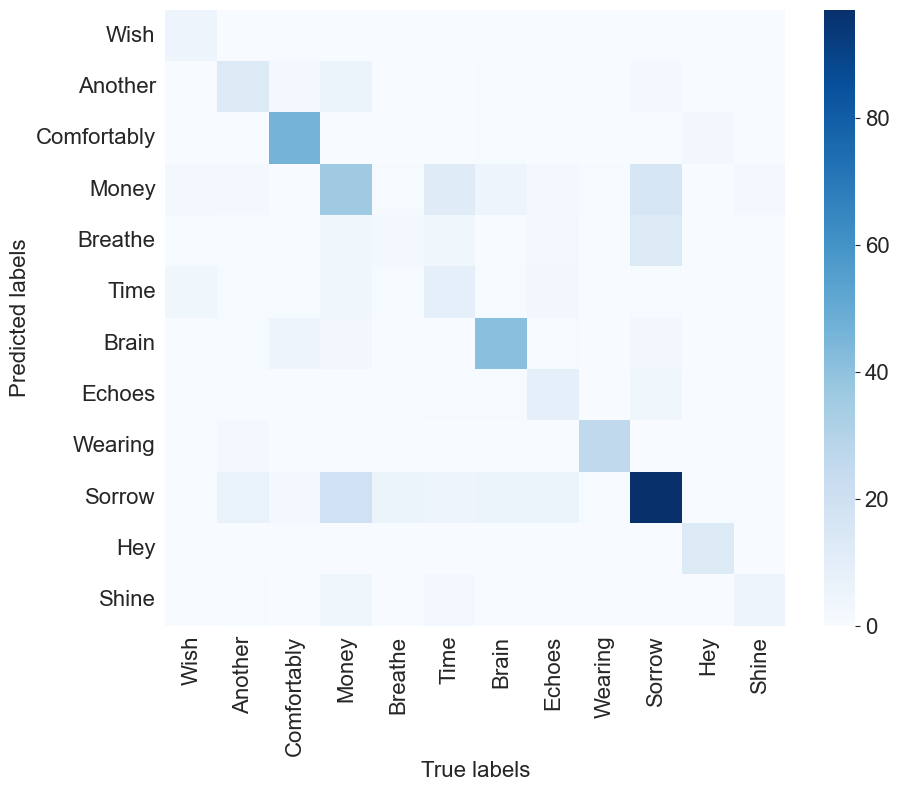

In [294]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Vanilla LSTM

In [295]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)

    lstm = tfkl.LSTM(128)(dropout)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [296]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 36, 128)           69120     
                                                                 
 dropout_18 (Dropout)        (None, 36, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               33024     
                                                                 
 dense_23 (Dense)            (None, 12)                3084  

In [297]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-12 19:35:54.092015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:35:54.228570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:35:54.353723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:35:54.506427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:35:54.728794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/41 [============================>.] - ETA: 0s - loss: 2.1034 - accuracy: 0.3346

2022-12-12 19:35:56.973455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:35:57.034423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:35:57.143015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 5s 71ms/step - loss: 2.0989 - accuracy: 0.3350 - val_loss: 1.8136 - val_accuracy: 0.4041 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 2s 37ms/step - loss: 1.7971 - accuracy: 0.3897 - val_loss: 1.6726 - val_accuracy: 0.4281 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 2s 37ms/step - loss: 1.6906 - accuracy: 0.4108 - val_loss: 1.5951 - val_accuracy: 0.4726 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 1s 35ms/step - loss: 1.6065 - accuracy: 0.4390 - val_loss: 1.5286 - val_accuracy: 0.4863 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 1s 35ms/step - loss: 1.5515 - accuracy: 0.4516 - val_loss: 1.4852 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 1s 35ms/step - loss: 1.4932 - accuracy: 0.4728 - val_loss: 1.4586 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 1s 34ms/step - loss: 1.4489 -

2022-12-12 19:38:34.524287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:34.691836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/16 [======>.......................] - ETA: 0s 

2022-12-12 19:38:34.895016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 25ms/step
Accuracy: 0.4866
Precision: 0.5414
Recall: 0.3941
F1: 0.428


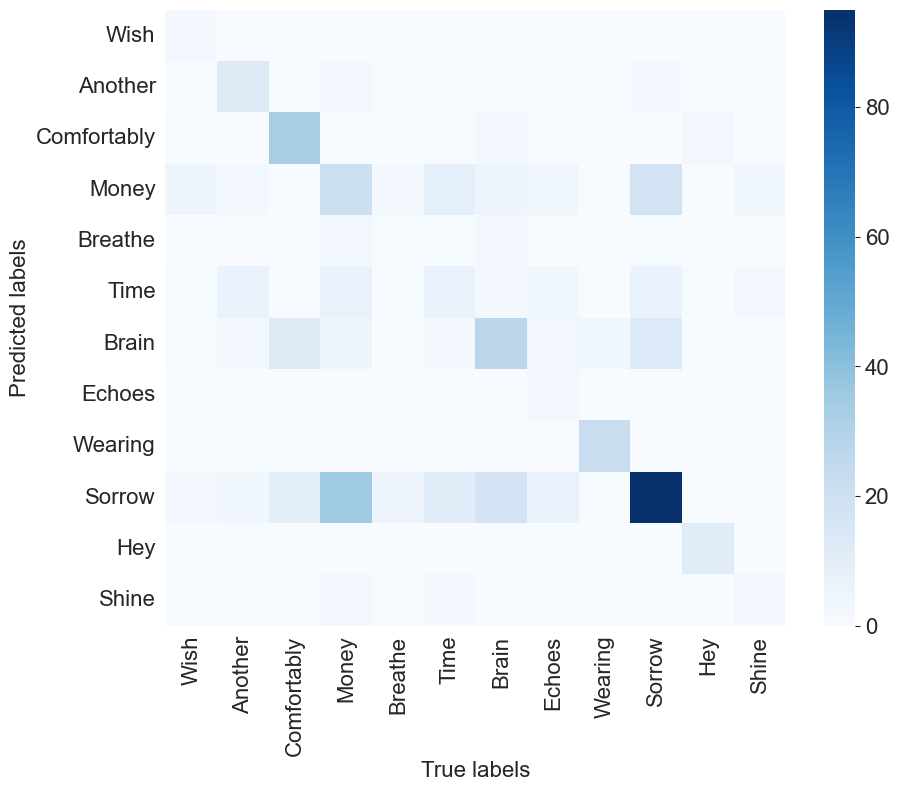

16/16 [==============================] - 0s 14ms/step
Accuracy: 0.4866
Precision: 0.5414
Recall: 0.3941
F1: 0.428


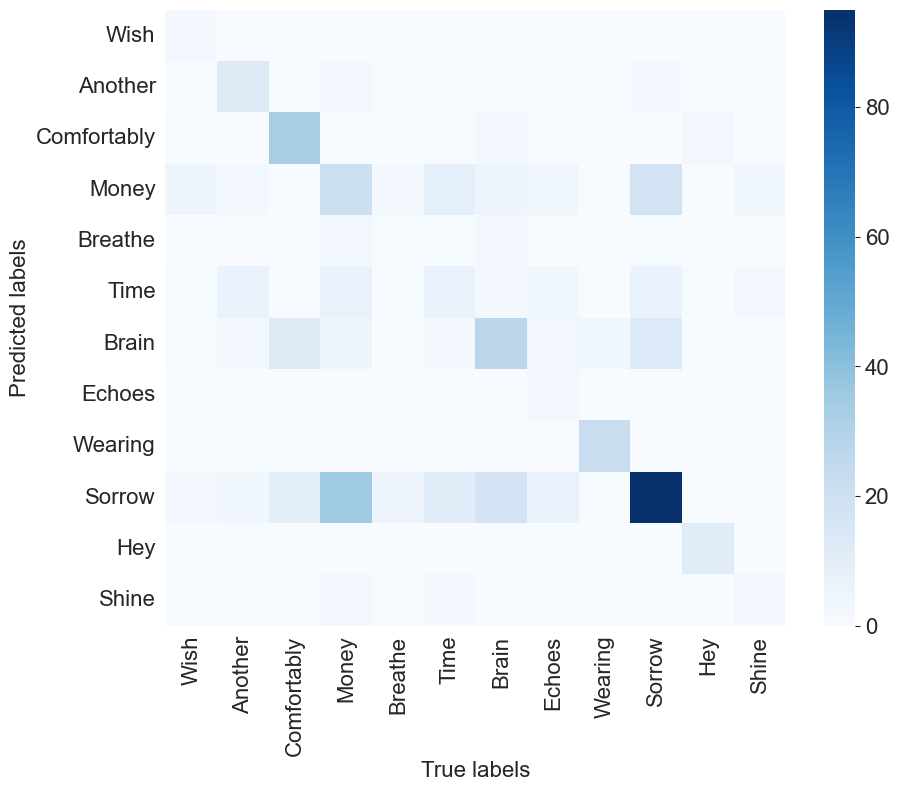

In [299]:
# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Bidirectional-LSTM

In [300]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64))(bilstm)
    dropout = tfkl.Dropout(.2, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [301]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 36, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                             

In [302]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-12 19:38:52.800049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.134598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.134638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.302474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.423981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.615116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.631122: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - ETA: 0s - loss: 2.0191 - accuracy: 0.3544

2022-12-12 19:39:00.703929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:00.834830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:00.843495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.004557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.013282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.181292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.191254: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - 12s 172ms/step - loss: 2.0191 - accuracy: 0.3544 - val_loss: 1.6861 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 4s 89ms/step - loss: 1.6565 - accuracy: 0.4285 - val_loss: 1.5348 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 4s 87ms/step - loss: 1.5245 - accuracy: 0.4705 - val_loss: 1.4584 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 4s 99ms/step - loss: 1.4548 - accuracy: 0.4882 - val_loss: 1.4107 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 4s 88ms/step - loss: 1.3972 - accuracy: 0.4987 - val_loss: 1.4095 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 3s 85ms/step - loss: 1.3546 - accuracy: 0.5158 - val_loss: 1.3105 - val_accuracy: 0.5599 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 3s 85ms/step - loss: 1.3160

In [303]:
#model.save('Preprocessing-BiLSTM')

16/16 [==============================] - 1s 47ms/step
Accuracy: 0.5134
Precision: 0.5267
Recall: 0.4317
F1: 0.4572


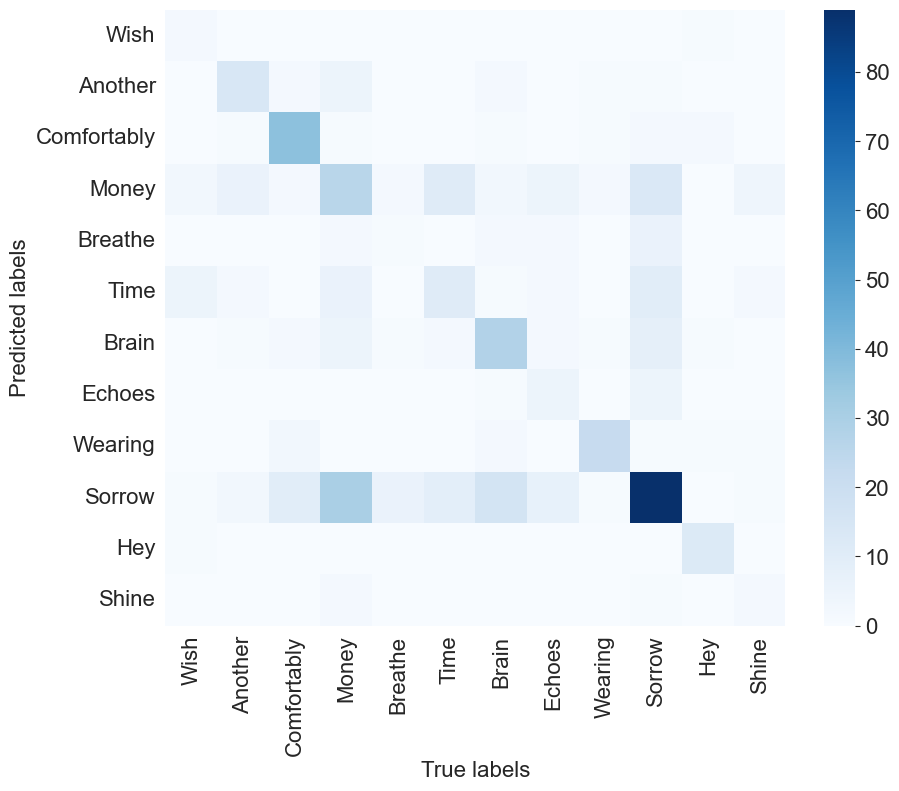

In [305]:
# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### HYBRID CNN-LSTM


In [66]:
def build_Hybrid(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256, 7, padding='same', activation='relu')(input_layer)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.2, seed=seed)(gap)

    lstm = tfkl.LSTM(128, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    lstm = tfkl.LSTM(128)(lstm)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE
    dropout = tfkl.Dropout(.2, seed=seed)(lstm)

    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model